# Tutorial with LSST

We will use the parameter file "tests/parametersTest.cfg".
This contains a description of the bands and data to be used.
In this example we will generate mock data for the ugrizy LSST bands,
**fit each object with our GP using ugi bands only and see how it predicts the rz bands.**
This is an example for filling in/predicting missing bands in a fully bayesian way
with a flexible SED model quickly via our photo-z GP.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import sys
sys.path.append('../')
from delight.io import *
from delight.utils import *
from delight.photoz_gp import PhotozGP

In [2]:
#%cd /Users/sylvie/MacOSX/GitHub/LSST/Delight
%cd ..

/Users/sylvie/MacOSX/GitHub/LSST/Delight


In [3]:
%mkdir tests_lsst

mkdir: tests_lsst: File exists


In [4]:
%mkdir data_lsst

mkdir: data_lsst: File exists


## Creating the parameter file
Let's create a parameter file from scratch.

In [5]:
paramfile_txt = """
# DELIGHT parameter file
# Syntactic rules:
# - You can set parameters with : or =
# - Lines starting with # or ; will be ignored
# - Multiple values (band names, band orders, confidence levels)
#   must beb separated by spaces
# - The input files should contain numbers separated with spaces.
# - underscores mean unused column
"""

Let's describe the bands we will use. This must be a superset (ideally the union) of all the bands involved in the training and target sets, including cross-validation. 

Each band should have its own file, containing a tabulated version of the filter response.

See example files shipped with the code for formatting.

In [6]:
paramfile_txt += """
[Bands]
names: lsst_u lsst_g lsst_r lsst_i lsst_z lsst_y
directory: data/FILTERS
"""

Let's now describe the system of SED templates to use (needed for the mean fct of the GP, for simulating objects, and for the template fitting routines).

Each template should have its own file (see shipped files for formatting example). 

- **lambdaRef** will be the pivot wavelenght used for normalizing the templates.

- **$p(z|t)$ and $p(t)$** containts parameters for the priors of each template, for $p(z|t) p(t)$. 

- Calibrating those numbers will be the topic of another tutorial.

By default the set of templates and the prior calibration can be left untouched.

In [7]:
paramfile_txt += """
[Templates]
directory: ./data/CWW_SEDs
names: El_B2004a Sbc_B2004a Scd_B2004a SB3_B2004a SB2_B2004a Im_B2004a ssp_25Myr_z008 ssp_5Myr_z008
p_t: 0.27 0.26 0.25 0.069 0.021 0.11 0.0061 0.0079
p_z_t:0.23 0.39 0.33 0.31 1.1 0.34 1.2 0.14
lambdaRef: 4.5e3
"""

The next section if for simulating a photometric catalogue from the templates. 

- **catalog files** (trainingFile, targetFile) will be created, and have the adequate format for the later stages. 

- **noiseLevel** describes the relative error for the absolute flux in each band.

In [8]:
paramfile_txt += """
[Simulation]
numObjects: 1000
noiseLevel: 0.03
trainingFile: data_lsst/galaxies-fluxredshifts.txt
targetFile: data_lsst/galaxies-fluxredshifts2.txt
"""

We now describe the training file.

- `catFile` is the input catalog. This should be a tab or space separated file with numBands + 1 columns.

- `bandOrder` describes the ordering of the bands in the file. Underscore `_` means an ignored column, for example a band that shouldn't be used. The band names must correspond to those in the filter section.

- `redshift` is for the photometric redshift. 
- `referenceBand` is the reference band for normalizing the fluxes and luminosities. 
- `extraFracFluxError` is an extra relative error to add in quadrature to the flux errors.

- `paramFile` will contain the output of the GP applied to the training galaxies, i.e. the minimal parameters that must be stored in order to reconstruct the fit of each GP.

- `crossValidate` is a flag for performing optional cross-validation. If so, `CVfile` will contain cross-validation data. `crossValidationBandOrder` is similar to `bandOrder` and describes the bands to be used for cross-validation. In this example I have left the R band out of `bandOrder` and put it in `crossValidationBandOrder`. However, this feature won't work on simulated data, only on real data (i.e., the `simulateWithSEDs` script below does not generate cross-validation bands).

- `numChunks` is the number of chunks to split the training data into. At present please stick to 1.

In [9]:
paramfile_txt += """
[Training]
catFile: data_lsst/galaxies-fluxredshifts.txt
bandOrder: lsst_u lsst_u_var lsst_g lsst_g_var _ _ lsst_i lsst_i_var lsst_z lsst_z_var lsst_y lsst_y_var redshift
referenceBand: lsst_i
extraFracFluxError: 1e-4
paramFile: data_lsst/galaxies-gpparams.txt
crossValidate: False
CVfile: data_lsst/galaxies-gpCV.txt
crossValidationBandOrder: _ _ _ _ lsst_r lsst_r_var _ _ _ _ _ _
numChunks: 1
"""

The section of the target catalog has very similar structure and parameters. The `catFile`, `bandOrder`, `referenceBand`, and `extraFracFluxError` have the same meaning as for the training, but of course don't have to be the same.

- `redshiftpdfFile` and `redshiftpdfFileTemp` will contain tabulated redshift posterior PDFs for the delight-apply and templateFitting scripts. 

- Similarly, `metricsFile` and `metricsFileTemp` will contain metrics calculated from the PDFs, like mean, mode, etc. This is particularly informative if `redshift` is also provided in the target set.

- The compression mode can be activated with `useCompression` and will produce new redshift PDFs in the file `redshiftpdfFileComp`, while `compressIndicesFile` and `compressMargLikFile` will contain the indices and marginalized likelihood for the objects that were kept during compression. The number of objects is controled with `Ncompress`.

In [10]:
paramfile_txt += """
[Target]
catFile: data_lsst/galaxies-fluxredshifts2.txt
bandOrder: lsst_u lsst_u_var lsst_g lsst_g_var lsst_r lsst_r_var _ _ lsst_z lsst_z_var lsst_y lsst_y_var redshift
referenceBand: lsst_r
extraFracFluxError: 1e-4
redshiftpdfFile: data_lsst/galaxies-redshiftpdfs.txt
redshiftpdfFileTemp: data_lsst/galaxies-redshiftpdfs-cww.txt
metricsFile:  data_lsst/galaxies-redshiftmetrics.txt
metricsFileTemp:  data_lsst/galaxies-redshiftmetrics-cww.txt
useCompression: False
Ncompress: 10
compressIndicesFile: data_lsst/galaxies-compressionIndices.txt
compressMargLikFile: data_lsst/galaxies-compressionMargLikes.txt
redshiftpdfFileComp: data_lsst/galaxies-redshiftpdfs-comp.txt
"""

Finally, there are various other parameters related to the method itself.

- The (hyper)parameters of the Gaussian process are `zPriorSigma`, `ellPriorSigma` (locality of the model predictions in redshift and luminosity), `fluxLuminosityNorm` (some normalization parameter), `alpha_C`, `alpha_L`, `V_C`, `V_L` (smoothness and variance of the latent SED model), `lines_pos`, `lines_width` (positions and widths of the lines in the latent SED model). 

- `redshiftMin`, `redshiftMax`, and `redshiftBinSize` describe the linear fine redshift grid to compute PDFs on.

- `redshiftNumBinsGPpred` describes the granuality (in log scale!) for the GP kernel to be exactly calculated on; it will then be interpolated on the finer grid.

- `redshiftDisBinSize` is the binsize for a tomographic redshift binning.

- `confidenceLevels` are the confidence levels to compute in the redshift PDF metrics.

The values below should be a good default set for all of those parameters. 

In [11]:
paramfile_txt += """
[Other]
rootDir: ./
zPriorSigma: 0.2
ellPriorSigma: 0.5
fluxLuminosityNorm: 1.0
alpha_C: 1.0e3
V_C: 0.1
alpha_L: 1.0e2
V_L: 0.1
lines_pos: 6500 5002.26 3732.22
lines_width: 20.0 20.0 20.0
redshiftMin: 0.1
redshiftMax: 1.101
redshiftNumBinsGPpred: 100
redshiftBinSize: 0.001
redshiftDisBinSize: 0.2
confidenceLevels: 0.1 0.50 0.68 0.95
"""

In [12]:
with open('tests_lsst/parametersTest.cfg','w') as out:
    out.write(paramfile_txt)

## Running Delight

### Processing the filters and templates, and create a mock catalog

- First, we must fit the band filters with a gaussian mixture. 
This is done with this script:

In [13]:
%run ./scripts/processFilters.py tests_lsst/parametersTest.cfg

lsst_u lsst_g lsst_r 

/Users/sylvie/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:475: RuntimeWarning: Number of calls to function has reached maxfev = 8600.
  warnings.warn(errors[info][0], RuntimeWarning)


lsst_i lsst_z lsst_y 

- Second, we will process the library of SEDs and project them onto the filters,
(for the mean fct of the GP) with the following script (which may take a few minutes depending on the settings you set):

In [14]:
%run ./scripts/processSEDs.py tests_lsst/parametersTest.cfg

- Third, we will make some mock data with those filters and SEDs:

produce files `galaxies-redshiftpdfs.txt` and `galaxies-redshiftpdfs2.txt` for trainning and target

In [15]:
%run ./scripts/simulateWithSEDs.py tests_lsst/parametersTest.cfg

### Train and apply
Run the scripts below. There should be a little bit of feedback as it is going through the lines.
For up to **1e4 objects** it should only take a few minutes max, depending on the settings above.

In [16]:
%run ./scripts/templateFitting.py tests_lsst/parametersTest.cfg

--- TEMPLATE FITTING ---
Thread number / number of threads:  1 1
Input parameter file: tests_lsst/parametersTest.cfg
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/templateFitting.py:63: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


In [17]:
%run ./scripts/delight-learn.py tests_lsst/parametersTest.cfg

--- DELIGHT-LEARN ---
Number of Training Objects 1000
Thread  0  analyzes lines  0  to  1000


/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-learn.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))


In [18]:
%run ./scripts/delight-apply.py tests_lsst/parametersTest.cfg

--- DELIGHT-APPLY ---
Number of Training Objects 1000
Number of Target Objects 1000
Thread  0  analyzes lines  0  to  1000


/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-apply.py:45: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTraining = np.sum(1 for line in open(params['training_catFile']))
/Users/sylvie/MacOSX/GitHub/LSST/Delight/scripts/delight-apply.py:46: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  numObjectsTarget = np.sum(1 for line in open(params['target_catFile']))


None band 1 y_pred_bin [2292.99529731 2158.84368634 2032.21639992 1908.42511027 1786.05187825
 1670.05775439 1566.22455403 1473.56616531 1388.27216696 1308.48250847
 1235.24986616 1167.04984268 1103.62004054 1044.96093223  989.54790294
  936.30961382  886.09314312  839.4509262   795.85114191  754.94731528
  716.47755277  680.14476536  645.6396389   612.7964881   581.59398228
  552.21512852  524.36342343  497.73304489  472.4183284   448.67918379
  426.13070613  404.67999905  384.07501884  364.52279313  345.86052038
  327.97624416  310.81794233  294.5952752   279.15575911  264.43675266
  250.23020286  236.69874731  223.96274814  211.82908923  200.52950207
  189.96472015  179.99500063  170.51297649  161.52423851  153.04884183
  144.93561453  137.20155681  129.85281179  122.88446025  116.32339605
  110.10903829  104.13417266   98.42133925   93.00178867   87.98827114
   83.26258161   78.68211157   74.09803232   69.88533739   65.52804736
   61.56759159   57.76697393   54.86193178   52.381558

 4.69243566e-01 4.18060646e-01 3.74996865e-01 3.38177604e-01] y_var_bin [-2.28866503e-06  1.35460502e-02  1.31726766e-02  1.14851579e-02
 -4.17043656e-06 -3.90427527e-06  9.53194538e-03  8.68591571e-03
  1.56677064e-03  5.98192955e-03  5.63950515e-03  6.04210654e-04
  6.02000201e-03  6.15926975e-03  4.60047002e-03  3.30687033e-04
  4.78485950e-03  3.78069965e-03  2.72196156e-03  2.47712082e-03
  2.24078994e-03  2.30370467e-03  1.86518053e-03  1.58643699e-03
  1.29095433e-03  4.38285610e-04 -9.96147279e-07  1.40112873e-03
  2.72391644e-04 -8.35550693e-07  9.52502135e-04  1.50335352e-06
  7.34076647e-04  5.81414167e-04  5.73350574e-04  4.31562161e-04
  4.80619452e-04  9.45688653e-05  3.23830776e-04  3.38955511e-04
  2.68518679e-04  6.86920422e-05  6.56161618e-05  1.97210704e-04
  1.67342639e-04  1.78423432e-04  1.41473024e-04  1.29048214e-04
  1.36873029e-04  1.02926734e-04 -2.65120180e-07  8.72866714e-05
  1.10891478e-04 -2.26231925e-07  6.38317410e-05  5.59996354e-05
  5.23478674e-05  

None band 1 y_pred_bin [1769.77665018 1675.86623041 1586.77148375 1502.41510844 1421.78350534
 1344.934985   1272.17706701 1203.30600778 1138.17247413 1076.57382525
 1018.082173    962.32484678  909.39532507  859.49227465  812.39043609
  767.57199294  725.02423817  684.86876632  646.98878111  611.13007254
  577.20441346  545.10366842  514.7017632   485.84228066  458.5197651
  432.66016575  408.17911444  384.97202166  362.98182941  342.21449768
  322.61264033  304.08606482  286.59957791  270.10003287  254.56141494
  239.93694134  226.16787201  213.20972639  201.03544526  189.65209167
  178.85401044  168.60350685  158.98108711  149.82386831  141.10805911
  132.89743641  125.0879445   117.71025561  110.77565215  104.21216519
   98.04857649   92.25288979   86.78302386   81.69751255   76.90339957
   72.4217166    68.28569735   64.43937      60.84413141   57.52538252
   54.35637048   51.44772206   48.63421234   46.03658959   43.56934713
   41.27702577   39.12795834   37.23992177   35.5331348

None band 0 y_pred_bin [556.69583592 524.15300735 493.39916634 464.48549697 437.16630606
 411.40071304 387.08501452 364.07419042 342.34137125 321.83713662
 302.4537961  284.1174947  266.78826633 250.41592915 234.95974493
 220.39559402 206.708744   193.83024243 181.74069586 170.39670875
 159.74925822 149.76501645 140.40476439 131.63266597 123.42002983
 115.72267291 108.51576326 101.76954918  95.45980758  89.55557351
  84.03226603  78.86674158  74.03629595  69.52089954  65.29900866
  61.35218092  57.66088813  54.20918794  50.98113926  47.96078125
  45.13494893  42.49090298  40.01625222  37.69964655  35.52931437
  33.49537154  31.58883691  29.80050764  28.12241128  26.54708101
  25.06780906  23.67774853  22.37089214  21.14171141  19.98527603
  18.89684288  17.87186683  16.90594153  15.99497444  15.13545974
  14.32373551  13.55700907  12.83243259  12.14729435  11.49919466
  10.88595388  10.30576064   9.75685755   9.23750769   8.74635291
   8.28199947   7.84325879   7.42897097   7.03796937 

None band 1 y_pred_bin [1985.71279898 1887.22840233 1793.38069501 1704.44430485 1619.81194092
 1539.40863108 1463.06376843 1390.41047899 1321.32843153 1255.6883925
 1193.40706487 1134.32133905 1078.09176051 1024.57411155  973.74523378
  925.53631014  879.77757224  836.12806168  794.5538638   755.05563719
  717.50473552  681.82068429  647.90414681  615.65432623  585.07460756
  556.04696708  528.40847642  502.12847885  477.16898259  453.45227673
  430.94486938  409.50189341  389.121788    369.78441878  351.40762101
  333.94813486  317.37005296  301.72435846  286.84856983  272.67205609
  259.26375138  246.53635051  234.33938955  222.75736198  211.65059911
  200.99880143  190.85127166  181.25089798  172.18132455  163.52179676
  155.33468575  147.61230651  140.23482323  133.29915721  126.61160015
  120.24894722  114.33744164  108.72259129  103.47644365   98.51635958
   93.82765054   89.51945538   85.50094492   81.82249596   78.44919447
   75.37303412   72.54367725   69.90951057   67.4025968

  7.90292557e-07  8.40569952e-07  7.65412852e-07  6.97104190e-07]
None band 1 y_pred_bin [1792.25076555 1693.6399337  1599.89871156 1511.3184828  1427.24785332
 1347.60781853 1272.2802134  1200.90423251 1133.30931566 1069.31702117
 1008.73813951  951.38184988  897.06588808  845.68927362  797.05671955
  750.98217881  707.42873511  666.1741517   627.1270516   590.20231905
  555.25611473  522.20074708  490.9417549   461.38236695  433.46959026
  407.08575524  382.15774687  358.59849168  336.34984458  315.33202322
  295.48646891  276.75877517  259.09457662  242.44807608  226.77452508
  212.03755877  198.2005862   185.23168852  173.08687851  161.71345903
  151.05309966  141.04659077  131.63787878  122.77244941  114.40274436
  106.50067494   99.04796495   92.03459632   85.44689255   79.26578724
   73.4716354    68.04602965   62.97055343   58.23312094   53.82044647
   49.73988666   45.98302592   42.53666814   39.3600418    36.41824776
   33.68535588   31.15256771   28.8099806    26.64530878   

  7.32057229e-07  7.78578889e-07  7.08961653e-07  6.45688128e-07]
None band 1 y_pred_bin [1812.5740433  1713.6326165  1619.45233524 1530.36572823 1445.78378041
 1365.66899525 1289.9261897  1218.21785687 1150.40286692 1086.31689475
 1025.7541128   968.49251065  914.32647446  863.13659853  814.70648591
  768.83562816  725.49417092  684.47126666  645.6764171   609.01381721
  574.32289444  541.4975717   510.43292519  481.03205563  453.2382451
  426.93383513  402.05783709  378.53434243  356.30839679  335.30245183
  315.46100819  296.72500808  279.03354405  262.33983677  246.59321344
  231.74787843  217.76526451  204.61211774  192.24420489  180.61686499
  169.67859316  159.37514383  149.66255721  140.49380541  131.82536084
  123.62991747  115.88572219  108.57674843  101.6884018    95.20178816
   89.09605433   83.35457751   77.95530372   72.88291593   68.12310223
   63.6824742    59.5561763    55.73424047   52.1859724    48.88054013
   45.78757108   42.88459244   40.1559002    37.59405355   3

None band 1 y_pred_bin [2010.46154234 1900.9745703  1796.39761373 1697.0252568  1602.45002929
 1512.98602905 1428.83559558 1349.72498356 1275.39013062 1205.4403202
 1139.46098382 1077.18705271 1018.48897739  963.26074611  911.10283578
  861.62508878  814.80435172  770.55391549  728.85135432  689.53248994
  652.33351171  617.0923895   583.67717381  551.9770282   521.9317567
  493.42908372  466.41709696  440.810709    416.55265636  393.57003701
  371.80642198  351.18997109  331.65071418  313.13963864  295.60861512
  279.01741506  263.32638041  248.49735998  234.48699972  221.25237878
  208.72736983  196.86974815  185.66961284  175.07387149  165.04229676
  155.55637194  146.56882284  138.03857368  129.95656831  122.30979606
  115.06543409  108.21967392  101.76407609   95.67302303   89.93932222
   84.56830764   79.53035194   74.79990835   70.38167343   66.2476486
   62.3563924    58.62424839   55.02878863   51.58658247   48.26362041
   45.13983524   42.31496982   39.92193772   37.8625093  

None band 1 y_pred_bin [2345.11661314 2207.91562677 2078.41009137 1951.80495989 1826.65010427
 1708.01935802 1601.8259601  1507.06138358 1419.82859492 1338.22527217
 1263.32800965 1193.57773503 1128.70612899 1068.71365814 1012.0410516
  957.59261867  906.23469211  858.53226441  813.9414258   772.10782577
  732.76361776  695.60495976  660.31550671  626.72580723  594.81404573
  564.76738915  536.28259474  509.04688784  483.15674927  458.87799639
  435.81697516  413.87867764  392.805331    372.80866871  353.72218868
  335.43138962  317.8830669   301.29164651  285.50117874  270.44759833
  255.91812313  242.07908755  229.05358962  216.64412359  205.08768832
  194.2827609   184.08642207  174.38886517  165.19580693  156.52775651
  148.23010965  140.32025057  132.80446294  125.67771542  118.96751317
  112.61189819  106.50121931  100.6585288    95.11578766   89.98830897
   85.15520083   80.47061315   75.78233428   71.47388154   67.01754704
   62.96706709   59.08005851   56.10898238   53.5722278

None band 1 y_pred_bin [2013.4469982  1913.58701156 1818.42852558 1728.2499803  1642.43557425
 1560.90928847 1483.49813325 1409.83011058 1339.78320858 1273.22640108
 1210.07518873 1150.16422652 1093.14929976 1038.88418167  987.34538712
  938.46313899  892.06529777  847.806143    805.65128633  765.60139555
  727.52602755  691.34358387  656.95334042  624.25309252  593.24627248
  563.81320815  535.78869558  509.14164991  483.83354867  459.78559564
  436.96383111  415.22136465  394.55661363  374.94916248  356.31569888
  338.6123588   321.80273335  305.93851776  290.85496115  276.48044608
  262.88486944  249.97970669  237.61239241  225.86860017  214.60671056
  203.80614057  193.5168815   183.78242227  174.5861734   165.80569688
  157.5042402   149.67400248  142.19347861  135.16094278  128.37998121
  121.92846061  115.93439052  110.24111797  104.92169772   99.89233645
   95.13814045   90.7697729    86.69513602   82.96531023   79.54489383
   76.4257687    73.55689364   70.88593591   68.344008

None band 0 y_pred_bin [4.18110892e+02 3.93644362e+02 3.70535062e+02 3.48830900e+02
 3.28321889e+02 3.08989759e+02 2.90824698e+02 2.73714543e+02
 2.57589685e+02 2.42403399e+02 2.28077839e+02 2.14529792e+02
 2.01720521e+02 1.89634006e+02 1.78193091e+02 1.67346782e+02
 1.57094697e+02 1.47372397e+02 1.38173313e+02 1.29488788e+02
 1.21283117e+02 1.13541537e+02 1.06237262e+02 9.93421824e+01
 9.28388213e+01 8.66987936e+01 8.09041771e+01 7.54330495e+01
 7.02640372e+01 6.53767198e+01 6.07579793e+01 5.63913956e+01
 5.22618761e+01 4.83519002e+01 4.46528433e+01 4.11590929e+01
 3.78665061e+01 3.47600273e+01 3.18479706e+01 2.91332192e+01
 2.66159280e+01 2.42966311e+01 2.21820537e+01 2.02579116e+01
 1.85100091e+01 1.69203179e+01 1.54634992e+01 1.41180279e+01
 1.28692359e+01 1.17026166e+01 1.06117995e+01 9.59683553e+00
 8.65614368e+00 7.79004629e+00 6.99796606e+00 6.27677599e+00
 5.62231569e+00 5.03083881e+00 4.49842283e+00 4.02096038e+00
 3.59342454e+00 3.21170969e+00 2.87093949e+00 2.56717036e+00
 

None band 0 y_pred_bin [4.13488311e+02 3.89290282e+02 3.66436469e+02 3.44972724e+02
 3.24690661e+02 3.05572451e+02 2.87608393e+02 2.70687565e+02
 2.54741137e+02 2.39722874e+02 2.25555821e+02 2.12157676e+02
 1.99490125e+02 1.87537341e+02 1.76223008e+02 1.65496701e+02
 1.55358041e+02 1.45743303e+02 1.36645991e+02 1.28057544e+02
 1.19942651e+02 1.12286714e+02 1.05063241e+02 9.82444362e+01
 9.18130147e+01 8.57409059e+01 8.00103858e+01 7.45997751e+01
 6.94879364e+01 6.46546757e+01 6.00870198e+01 5.57687307e+01
 5.16848827e+01 4.78181492e+01 4.41600008e+01 4.07048873e+01
 3.74487115e+01 3.43765845e+01 3.14967282e+01 2.88119937e+01
 2.63225340e+01 2.40288774e+01 2.19376744e+01 2.00347991e+01
 1.83062127e+01 1.67340868e+01 1.52933630e+01 1.39627548e+01
 1.27277564e+01 1.15740217e+01 1.04952509e+01 9.49149428e+00
 8.56118825e+00 7.70465156e+00 6.92131323e+00 6.20808088e+00
 5.56084015e+00 4.97588615e+00 4.44933978e+00 3.97713912e+00
 3.55431291e+00 3.17680098e+00 2.83978098e+00 2.53935296e+00
 

None band 1 y_pred_bin [1984.13939777 1885.73300284 1791.95968673 1703.09376488 1618.52845905
 1538.18885648 1461.90448543 1389.30876263 1320.2814522  1254.69350111
 1192.46144389 1133.42253462 1077.23750961 1023.76226542  972.97366201
  924.80293682  879.080456    835.4655313   793.92427494  754.45734498
  716.936197    681.28042029  647.39075686  615.16648972  584.6110012
  555.60636108  527.98977011  501.73059584  476.79087659  453.09296302
  430.60338978  409.17740453  388.81344767  369.49140079  351.12916426
  333.68351253  317.11856666  301.48526942  286.621268    272.45598742
  259.05830716  246.34099124  234.15369494  222.58084478  211.48288275
  200.83952542  190.70003644  181.10727924  172.04488324  163.3922158
  155.21159432  147.49533359  140.12369622  133.19352604  126.51126823
  120.15364867  114.24683585  108.63643476  103.39444423   98.43829061
   93.75329699   89.44851573   85.43318962   81.75765557   78.38702719
   75.3133045    72.48618942   69.85411047   67.34918338

None band 0 y_pred_bin [782.04301166 739.9971855  700.24792357 662.84900957 627.49834009
 594.12525415 562.56472497 532.64169746 504.31378041 477.48030834
 452.01815156 427.84786382 404.9096938  383.1545212  362.51950165
 342.94681932 324.42105042 306.85752006 290.22569375 274.48731665
 259.58293829 245.4740862  232.12126172 219.48530468 207.54025196
 196.23470989 185.54072219 175.42471867 165.8612912  156.81514473
 148.25881037 140.16585026 132.5103877  125.27085386 118.42227955
 111.94382531 105.81363297 100.01397942  94.52848291  89.33983589
  84.43304971  79.79530035  75.41375803  71.27593529  67.36877834
  63.68037633  60.20048101  56.91726477  53.82166171  50.9035575
  48.15385881  45.56324561  43.1222922   40.82296646  38.65786168
  36.62024564  34.7025766   32.89774249  31.19939755  29.6015506
  28.09794263  26.68324535  25.35196605  24.09901687  22.91944139
  21.80833834  20.76174568  19.77531266  18.84510556  17.96743507
  17.13886673  16.35605985  15.6157726   14.91543062  1

None band 0 y_pred_bin [777.2842605  735.49431496 695.98692126 658.81559852 623.6800429
 590.51003553 559.14155683 529.40061424 501.24507512 474.57488749
 449.26767011 425.24446133 402.44587096 380.82307962 360.31362583
 340.86004432 322.44700551 304.99034984 288.45972858 272.81711971
 258.00343452 243.98043467 230.70886185 218.1497942  206.27742656
 195.04067806 184.4117625  174.35731401 164.85207905 155.86097736
 147.35670722 139.31299163 131.70411139 124.50862889 117.7017269
 111.26269278 105.16980138  99.40543742  93.95331885  88.79624344
  83.91931374  79.30978377  74.95490182  70.84225641  66.9588732
  63.2929138   59.83419234  56.57095317  53.49418557  50.59383674
  47.8608687   45.28601813  42.85991668  40.57458112  38.42264981
  36.39743148  34.4914303   32.69757747  31.00956585  29.42144072
  27.92698114  26.52089126  25.1977118   23.95238584  22.77998714
  21.67564424  20.63541922  19.6549878   18.73044021  17.85810957
  17.03458232  16.25653811  15.52075484  14.8246738   14

  1.46469754e-06  1.03064202e-06  3.99872992e-07  3.80441394e-07]
None band 1 y_pred_bin [1996.62992007 1897.60392378 1803.24028002 1713.8149378  1628.7172844
 1547.87193546 1471.10734611 1398.05462542 1328.5927806  1262.59188376
 1199.96813138 1140.55756566 1084.01884969 1030.20697288  979.09864952
  930.62468417  884.61437513  840.7248895   798.92212618  759.20674734
  721.44939938  685.5691654   651.46616255  619.03903983  588.29120087
  559.10397305  531.3135323   504.88905333  479.79233547  455.94524061
  433.3140927   411.75322818  391.26107764  371.81739601  353.33956685
  335.78409247  319.1148681   303.38315718  288.42558489  274.17113196
  260.68911149  247.89173831  235.62772131  223.98201846  212.81419323
  202.10383451  191.90051605  182.24736382  173.12792603  164.42078348
  156.18866847  148.42383346  141.00579056  134.03199393  127.30767033
  120.91003605  114.96603153  109.32031212  104.04532245   99.05796907
   94.34348267   90.01160212   85.97099887   82.27232669   7

  1.47627557e-06  1.03886232e-06  4.03229052e-07  3.83623492e-07]
None band 0 y_pred_bin [766.66596933 725.44686335 686.47909996 649.81561714 615.16003203
 582.44314262 551.50317792 522.16851388 494.39760063 468.09173954
 443.13023443 419.4351978  396.94805077 375.6206413  355.39135985
 336.20352743 318.0420235  300.82383809 284.51903709 269.09011785
 254.47879884 240.64736405 227.55709146 215.1695909  203.45940972
 192.37616481 181.89244955 171.97535384 162.59996914 153.73169438
 145.34360077 137.4097703  129.90483505 122.8076503  116.09373781
 109.74266788 103.73301213  98.04739592  92.66975962  87.58313597
  82.77283105  78.22627299  73.93088427  69.87442296  66.04409195
  62.42821459  59.01674412  55.79808551  52.7633511   49.90262544
  47.20699401  44.66732002  42.27436311  40.02024909  37.89771688
  35.90016664  34.02020491  32.25085947  30.58590934  29.01948113
  27.54543889  26.15855911  24.85345709  23.62514498  22.46876385
  21.37950878  20.35349564  19.38645922  18.47454317 

None band 1 y_pred_bin [2007.6692448  1898.33435003 1793.90264589 1694.66830725 1600.22443525
 1510.88469151 1426.85113452 1347.85039917 1273.61878983 1203.76613307
 1137.878436   1075.69099587 1017.07444617  961.92292123  909.83745286
  860.42842532  813.6727174   769.48374038  727.83909968  688.57484503
  651.42753222  616.23535615  582.86655057  551.21043301  521.20689109
  492.74380516  465.76933532  440.19851144  415.97415046  393.02345132
  371.2900634   350.70224632  331.1901271   312.70476121  295.19808613
  278.62992917  262.96068739  248.15226256  234.16136086  220.94512105
  208.43750764  196.59635455  185.41177466  174.83074926  164.81310691
  155.34035661  146.36528982  137.84688803  129.77610703  122.13995492
  114.90565357  108.06940151  101.62276931   95.54017558   89.81443776
   84.45088257   79.41992342   74.69604937   70.28395038   66.15566672
   62.26981452   58.54285351   54.9523869    51.51496104   48.19661365
   45.07716651   42.25622395   39.86651494   37.809946

None band 1 y_pred_bin [2030.62590277 1929.91393096 1833.94354246 1742.99557907 1656.44899094
 1574.22711018 1496.15547108 1421.85890167 1351.21434904 1284.08966672
 1220.39964334 1159.9775104  1102.47612544 1047.74800881  995.76947834
  946.47016043  899.67644686  855.03966739  812.52514027  772.13353899
  733.73330747  697.24215104  662.5584862   629.57923624  598.30786277
  568.62367256  540.36005212  513.48565132  487.96161908  463.70848682
  440.6920051   418.7640302   397.92296597  378.14822265  359.35577709
  341.50139101  324.54834486  308.54877495  293.33652472  278.83936565
  265.12779103  252.11252101  239.63968843  227.79569787  216.43772158
  205.54500092  195.16795375  185.35043826  176.07572877  167.22033807
  158.84805715  150.95100748  143.40665993  136.31412272  129.47530621
  122.9687421   116.92353029  111.18168305  105.81687785  100.74460645
   95.94984805   91.54421002   87.43480879   83.67316061   80.22356174
   77.07782478   74.18447444   71.49072726   68.927112

None band 1 y_pred_bin [2119.17705037 2020.1312314  1925.66504995 1836.04465097 1750.66056893
 1669.43980862 1592.23297244 1518.68670744 1448.66091537 1382.01407221
 1318.66405233 1258.4456649  1201.03191898 1146.29118078 1094.1810488
 1044.62627118  997.4939322   952.44529388  909.44312759  868.4935551
  829.45818155  792.25481241  756.78279318  722.94972553  690.77165822
  660.10598586  630.80876679  602.84577585  576.18453256  550.74418858
  526.46187118  503.22874907  481.06129556  459.92698708  439.743166
  420.46961631  402.08529318  384.61048321  367.91834513  351.97015593
  336.80144315  322.33365295  308.45513784  295.22800722  282.53548967
  270.35791625  258.74367     247.70645136  237.22034593  227.19810183
  217.66474298  208.62591902  199.98036617  191.78536094  183.89938215
  176.35970626  169.26398828  162.48706225  156.07615875  149.97647368
  144.17001824  138.7344584   133.58303793  128.73687075  124.14612988
  119.80213887  115.66319095  111.71082968  107.90354728  

  1.55730084e-06  1.09587983e-06  4.25358994e-07  4.04677778e-07]
None band 0 y_pred_bin [4.23116854e+02 3.98354686e+02 3.74968930e+02 3.53005117e+02
 3.32250753e+02 3.12687346e+02 2.94304968e+02 2.76990115e+02
 2.60672909e+02 2.45304371e+02 2.30807422e+02 2.17097286e+02
 2.04134763e+02 1.91903642e+02 1.80325844e+02 1.69349765e+02
 1.58975019e+02 1.49136395e+02 1.39827246e+02 1.31038812e+02
 1.22734959e+02 1.14900751e+02 1.07509078e+02 1.00531495e+02
 9.39503171e+01 8.77368192e+01 8.18728645e+01 7.63362688e+01
 7.11054027e+01 6.61596015e+01 6.14855902e+01 5.70667526e+01
 5.28878153e+01 4.89310482e+01 4.51877236e+01 4.16521617e+01
 3.83201701e+01 3.51765131e+01 3.22296042e+01 2.94823609e+01
 2.69349399e+01 2.45878817e+01 2.24479919e+01 2.05008154e+01
 1.87319868e+01 1.71232621e+01 1.56489995e+01 1.42874166e+01
 1.30236699e+01 1.18430792e+01 1.07391977e+01 9.71207727e+00
 8.76011767e+00 7.88364517e+00 7.08207552e+00 6.35224431e+00
 5.68994138e+00 5.09137556e+00 4.55257742e+00 4.06939045e

None band 1 y_pred_bin [2047.39728398 1945.85351903 1849.09053832 1757.39141403 1670.13001701
 1587.22904609 1508.51259463 1433.60239167 1362.374369   1294.69528985
 1230.47923321 1169.55805901 1111.58175597 1056.4016266  1003.99379271
  954.28729962  907.10710523  862.10165956  819.23599443  778.51078887
  739.79340025  703.00085423  668.03072829  634.7790944   603.24944274
  573.32008327  544.8230264   517.72666307  491.99182129  467.53837618
  444.3317954   422.22271167  401.20951568  381.2714476   362.32379032
  344.32194018  327.22887435  311.09715976  295.75926752  281.14237255
  267.31755038  254.19478375  241.6189347   229.67712144  218.22533656
  207.24264999  196.77989598  186.88129675  177.52998313  168.60145253
  160.16001893  152.19774992  144.59109154  137.43997512  130.54467495
  123.98437071  117.88923047  112.09995973  106.69084513  101.57668044
   96.7423208    92.30029539   88.15695348   84.3642368    80.88614672
   77.71442823   74.79717948   72.08118529   69.496396

 4.76437850e-01 4.24470177e-01 3.80746115e-01 3.43362310e-01] y_var_bin [-3.56289603e-06  1.39685461e-02  1.35833305e-02  1.18434349e-02
 -1.06973937e-06 -1.00402133e-06  9.82925261e-03  8.95690587e-03
  1.61765482e-03  6.16906073e-03  5.81591522e-03  6.24923636e-04
  6.20790554e-03  6.35135945e-03  4.74429373e-03  3.42498985e-04
  4.93418448e-03  3.89891418e-03  2.80738535e-03  2.55490384e-03
  2.31120012e-03  2.37599157e-03  1.92385700e-03  1.63644331e-03
  1.33177707e-03  4.52714522e-04 -1.86671199e-07  1.44521019e-03
  2.81559389e-04 -1.48809981e-07  9.82603782e-04  2.18955292e-06
  7.57361774e-04  5.99951679e-04  5.91609517e-04  4.45412927e-04
  4.95959602e-04  9.79576396e-05  3.34279016e-04  3.49848940e-04
  2.77215154e-04  7.11953112e-05  6.80056909e-05  2.03647981e-04
  1.72840355e-04  1.84247519e-04  1.46140410e-04  1.33317358e-04
  1.41370231e-04  1.06362159e-04 -3.01024614e-08  9.02147067e-05
  1.14537507e-04 -2.38070956e-08  6.60029344e-05  5.79190898e-05
  5.41451694e-05  

   5.57287439   5.29467345   5.02284628   4.75737716   4.49731931] y_var_bin [-1.04190844e-06  5.19195748e-07  1.17885561e-07  1.80694661e-02
  8.36910788e-08  1.15644567e-02  4.49930616e-08  1.53531945e-07
  5.61873824e-03  9.04477273e-03  4.78637884e-03  6.31571557e-05
  3.01229593e-03  2.85821544e-03  3.06831283e-03 -7.87058690e-08
  5.88683122e-03  2.47956528e-03  2.22474321e-03  1.83185894e-03
  1.68993750e-03  9.12604600e-04  1.37867582e-03 -4.56566871e-08
  1.16345113e-03  9.26696671e-04  1.84105848e-03  8.31515261e-04
  1.54309665e-06  1.64188217e-03  6.58900858e-04  5.50762109e-04
  4.49901958e-04 -7.40506446e-09  6.02063783e-04  3.40487854e-04
  3.95932748e-04 -3.17400692e-09  2.63249697e-04  6.89994817e-04
  2.69339010e-04  5.20003661e-04 -5.07621249e-09  2.53877253e-04
  2.35787622e-04  1.79051616e-04  1.35111935e-04 -1.20460601e-09
  2.91040066e-10 -8.30225918e-10  1.20022245e-04  1.08685718e-04
 -6.70366642e-10  6.56322119e-05  6.95070116e-05 -1.73771732e-09
  5.00118373e

None band 0 y_pred_bin [4.21240537e+02 3.96591111e+02 3.73308925e+02 3.51442382e+02
 3.30779931e+02 3.11303161e+02 2.93002188e+02 2.75764011e+02
 2.59518499e+02 2.44218580e+02 2.29785825e+02 2.16136398e+02
 2.03231273e+02 1.91054311e+02 1.79527778e+02 1.68600299e+02
 1.58271490e+02 1.48476429e+02 1.39208497e+02 1.30458976e+02
 1.22191889e+02 1.14392365e+02 1.07033418e+02 1.00086727e+02
 9.35346856e+01 8.73486956e+01 8.15107009e+01 7.59986155e+01
 7.07909058e+01 6.58669987e+01 6.12136780e+01 5.68144010e+01
 5.26539622e+01 4.87147098e+01 4.49879548e+01 4.14680426e+01
 3.81507993e+01 3.50210566e+01 3.20871907e+01 2.93521061e+01
 2.68159587e+01 2.44792866e+01 2.23488651e+01 2.04103032e+01
 1.86492991e+01 1.70476898e+01 1.55799471e+01 1.42243853e+01
 1.29662264e+01 1.17908556e+01 1.06918546e+01 9.66927481e+00
 8.72152326e+00 7.84892465e+00 7.05089731e+00 6.32429085e+00
 5.66491372e+00 5.06899157e+00 4.53257254e+00 4.05151854e+00
 3.62076505e+00 3.23617577e+00 2.89283790e+00 2.58677836e+00
 

  7.56001974e-07  8.04083388e-07  7.32189452e-07  6.66846426e-07]
None band 1 y_pred_bin [1752.81983585 1656.37844993 1564.69953804 1478.06815269 1395.84715143
 1317.95926783 1244.28893662 1174.4832904  1108.37552145 1045.79106015
  986.54502122  930.4506206   877.32965791  827.08337431  779.52077933
  734.45991913  691.86468959  651.51774338  613.32971389  577.21735798
  543.04000092  510.71188045  480.14061361  451.2315582   423.93288714
  398.12951968  373.74994938  350.7090185   328.94986116  308.39445032
  288.98551561  270.66984755  253.39427685  237.1140139   221.78529474
  207.37255458  193.8400075   181.1564369   169.27882331  158.15562898
  147.72980681  137.94344984  128.7417377   120.07135549  111.88579122
  104.15757419   96.8688303    90.00976121   83.56699329   77.52187623
   71.85520274   66.54896441   61.58515305   56.95194816   52.63635632
   48.64557568   44.97136575   41.60083079   38.49409294   35.61702087
   32.94425493   30.46719025   28.17614202   26.0590948    

None band 1 y_pred_bin [2325.23309093 2189.19493735 2060.78747481 1935.25580435 1811.16212373
 1693.53723523 1588.24424007 1494.28316331 1407.79001159 1326.87859492
 1252.61637837 1183.45750921 1119.13594388 1059.65214186 1003.46005649
  949.47328619  898.5508182   851.25285446  807.04009699  765.56119976
  726.55058725  689.70699371  654.71675634  621.4118605   589.77067558
  559.97878155  531.73550684  504.73072874  479.06011005  454.98721428
  432.12172514  410.36944024  389.47477241  369.64765984  350.72301217
  332.58729899  315.18776676  298.73702339  283.08044145  268.15449887
  253.74821766  240.02652192  227.11146591  214.80721854  203.34876916
  192.63545569  182.52557063  172.91023839  163.79512722  155.20057236
  146.97328045  139.13048832  131.67842633  124.61210583  117.95879875
  111.65707243  105.59820543   99.80505454   94.30930977   89.2253065
   84.43317783   79.78831033   75.13978294   70.86786118   66.44931152
   62.43317521   58.57912421   55.63323957   53.1179939

None band 1 y_pred_bin [1964.96527456 1857.95598062 1755.74549382 1658.62191323 1566.18690399
 1478.74745601 1396.50132992 1319.18097519 1246.52830513 1178.16145786
 1113.67520791 1052.81052354  995.44077408  941.46234681  890.48475977
  842.12668449  796.36549156  753.11643407  712.35759376  673.92850766
  637.57133511  603.12771271  570.4686769   539.48589948  510.12054671
  482.26288374  455.86217336  430.83525276  407.12615522  384.66362816
  363.39251958  343.24261505  324.14552782  306.05335441  288.91905463
  272.70331028  257.36736079  242.87391829  229.18060985  216.2454859
  204.00391555  192.41462963  181.46795129  171.11198958  161.30742751
  152.03616739  143.25200485  134.91479257  127.01568252  119.54195566
  112.4615287   105.77068996   99.46118109   93.50796741   87.90401916
   82.65455236   77.7306019    73.10720734   68.78895624   64.74848359
   60.94528577   57.29759945   53.78350423   50.4191945    47.17143039
   44.11833583   41.35739653   39.01851825   37.0056942

None band 1 y_pred_bin [2020.50239091 1920.29247164 1824.80057728 1734.30602929 1648.19091368
 1566.37894483 1488.6965268  1414.77035802 1344.47799907 1277.68796066
 1214.31546112 1154.19455849 1096.97984259 1042.52456903  990.8051737
  941.75163387  895.19120682  850.77696058  808.47438631  768.28415415
  730.07536388  693.76613111  659.25537879  626.44054408  595.32507134
  565.78886906  537.66615438  510.92573347  485.52894893  461.39672838
  438.49499314  416.67633802  395.93917485  376.26301652  357.56425878
  339.79888388  322.93035534  307.01054956  291.87413833  277.44925322
  263.8060361   250.8556522   238.44500146  226.66005769  215.3587052
  204.52028886  194.19497515  184.426407    175.197932    166.38669756
  158.05613888  150.19846663  142.69173038  135.634552    128.82982943
  122.35570158  116.34062855  110.62740641  105.28934663  100.24236224
   95.47150734   91.0878329    86.99891841   83.25602328   79.82362177
   76.69356731   73.81463983   71.13432319   68.58348854

None band 1 y_pred_bin [2162.8026369  2061.71778392 1965.30695473 1873.8416237  1786.6998187
 1703.80704186 1625.01082004 1549.95052616 1478.48317791 1410.46431983
 1345.81020254 1284.35214193 1225.75647224 1169.888837   1116.7059618
 1066.13104567 1018.02843668  972.05242353  928.16501123  886.37244757
  846.53348868  808.56424797  772.36199886  737.8324409   704.99195324
  673.69499479  643.79466072  615.25602128  588.04592738  562.08186629
  537.29967101  513.58826983  490.96447518  469.39509396  448.79576695
  429.12545023  410.36266577  392.52811778  375.49235382  359.21585372
  343.73487641  328.96925092  314.80503139  301.3056058   288.35179886
  275.92353673  264.07019848  252.80576544  242.10379328  231.87523193
  222.14561645  212.92071846  204.09718737  195.7334789   187.68515853
  179.99027078  172.74847897  165.83204232  159.28916326  153.0639094
  147.13792163  141.59046474  136.33299654  131.38706561  126.70181921
  122.26840228  118.04424962  114.01052444  110.12486485 

None band 0 y_pred_bin [4.10858813e+02 3.86811065e+02 3.64103116e+02 3.42775917e+02
 3.22623093e+02 3.03626704e+02 2.85777107e+02 2.68964090e+02
 2.53119252e+02 2.38196682e+02 2.24119886e+02 2.10807096e+02
 1.98220251e+02 1.86343607e+02 1.75101349e+02 1.64443370e+02
 1.54369293e+02 1.44815800e+02 1.35776435e+02 1.27242693e+02
 1.19179486e+02 1.11572311e+02 1.04394844e+02 9.76194657e+01
 9.12290024e+01 8.51955623e+01 7.95015342e+01 7.41253771e+01
 6.90460885e+01 6.42436030e+01 5.97050302e+01 5.54142354e+01
 5.13563883e+01 4.75142726e+01 4.38794134e+01 4.04462957e+01
 3.72108482e+01 3.41582771e+01 3.12967515e+01 2.86291043e+01
 2.61554873e+01 2.38764252e+01 2.17985261e+01 1.99077539e+01
 1.81901598e+01 1.66280288e+01 1.51964627e+01 1.38743109e+01
 1.26471600e+01 1.15007558e+01 1.04288384e+01 9.43145769e+00
 8.50706008e+00 7.65596217e+00 6.87759657e+00 6.16889059e+00
 5.52575607e+00 4.94451176e+00 4.42130327e+00 3.95209458e+00
 3.53194613e+00 3.15682363e+00 2.82193550e+00 2.52340667e+00
 

  7.47355326e-07  7.94878042e-07  7.23810194e-07  6.59217417e-07]
None band 1 y_pred_bin [1.64626655e+03 1.55171879e+03 1.46190436e+03 1.37708918e+03
 1.29661844e+03 1.22039902e+03 1.14831821e+03 1.08003546e+03
 1.01538796e+03 9.54203936e+02 8.96315831e+02 8.41565290e+02
 7.89796202e+02 7.40919869e+02 6.94752418e+02 6.51122081e+02
 6.09995906e+02 5.71155105e+02 5.34518722e+02 5.00017717e+02
 4.67513479e+02 4.36917914e+02 4.08137567e+02 3.81071592e+02
 3.55654086e+02 3.31753389e+02 3.09286336e+02 2.88163579e+02
 2.68321622e+02 2.49678450e+02 2.32186374e+02 2.15802594e+02
 2.00476405e+02 1.86164312e+02 1.72810604e+02 1.60359281e+02
 1.48761251e+02 1.37975329e+02 1.27957995e+02 1.18664634e+02
 1.10035763e+02 1.02019621e+02 9.45749720e+01 8.76549061e+01
 8.12220478e+01 7.52343399e+01 6.96426396e+01 6.44083645e+01
 5.94958702e+01 5.48815626e+01 5.05405394e+01 4.64583786e+01
 4.26382657e+01 3.90987634e+01 3.58684080e+01 3.29694719e+01
 3.04033485e+01 2.81526030e+01 2.61647861e+01 2.43799094e

None band 1 y_pred_bin [2150.43145463 2049.92480695 1954.06540569 1863.123252   1776.47989509
 1694.06126215 1615.71575221 1541.08480093 1470.02624384 1402.39645495
 1338.11214148 1277.00563241 1218.74512854 1163.19705511 1110.31838495
 1060.03275647 1012.20529366  966.49226267  922.85588582  881.30237519
  841.6912948   803.93923788  767.94406545  733.61201645  700.95937633
  669.84143651  640.11213253  611.73673413  584.68228213  558.86673568
  534.22629481  510.65052312  488.15613688  466.71013287  446.22863437
  426.67083225  408.01537132  390.28283738  373.34451844  357.16112038
  341.76869474  327.08752912  313.00432942  299.58212104  286.70241038
  274.3452384   262.55970174  251.35970177  240.71894526  230.54889239
  220.87493031  211.70279932  202.92973934  194.61387181  186.61158833
  178.96071572  171.76034749  164.88347344  158.37802014  152.18837522
  146.29628458  140.78055962  135.55316462  130.63552488  125.97707855
  121.56902123  117.36903117  113.35837932  109.494946

None band 1 y_pred_bin [2138.16886709 2038.23521398 1942.92257646 1852.49901165 1766.34972882
 1684.40107891 1606.50232541 1532.2969487  1461.64359497 1394.39943964
 1330.48169697 1269.72366144 1211.79537265 1156.56406437 1103.98692866
 1053.98804809 1006.43331575  960.98095792  917.59341236  876.27685569
  836.89165276  799.35487242  763.56495814  729.42868352  696.96224113
  666.02174757  636.46197122  608.24838018  581.34820286  555.6798664
  531.1799346   507.73860084  485.37248606  464.04877522  443.68406991
  424.23779372  405.68871323  388.05729682  371.21556651  355.12445223
  339.81979993  325.22235179  311.21945974  297.87378978  285.06752402
  272.78081724  261.0624861   249.92635268  239.34627358  229.2342138
  219.61541668  210.49558826  201.77255578  193.50410837  185.54745685
  177.94021233  170.78090323  163.94324362  157.47488678  151.32053746
  145.46204565  139.97777335  134.78018682  129.89058922  125.258707
  120.87578598  116.69974574  112.71196405  108.87056152  

  7.63725909e-07  8.12259271e-07  7.39630753e-07  6.73620301e-07]
None band 1 y_pred_bin [1851.35517231 1750.2972962  1654.10177402 1563.10907808 1476.71742286
 1394.88850953 1317.52511849 1244.28252159 1175.01656934 1109.55940483
 1047.70084445  989.21407979  933.88911368  881.60398559  832.13766857
  785.28536409  741.01657904  699.1159546   659.49105618  622.04402892
  586.61086466  553.08321669  521.35391626  491.32399084  462.93550897
  436.06829477  410.66004979  386.63325607  363.93176871  342.47638508
  322.21041835  303.07354712  285.00356077  267.95267909  251.86914508
  236.70618328  222.42440126  208.9898336   196.35730064  184.48118587
  173.30888239  162.784984    152.86459035  143.49966736  134.6457561
  126.27496631  118.36507947  110.89972797  103.8640029    97.23859693
   91.00223143   85.13791379   79.62312005   74.44220632   69.58055446
   65.04491818   60.83033609   56.9266288    53.30244462   49.9262919
   46.76714824   43.80205998   41.01498711   38.39832962   35

None band 1 y_pred_bin [2040.82746385 1929.68695822 1823.53038539 1722.65710975 1626.6534193
 1535.838156   1450.41671546 1370.11121772 1294.65361203 1223.64728088
 1156.67139285 1093.45687691 1033.87222641  977.80982841  924.86412544
  874.63906695  827.11114985  782.19235536  739.85991899  699.94718272
  662.18635134  626.41294743  592.49302849  560.31408404  529.81500891
  500.88183168  473.46185629  447.46870925  422.84426307  399.51451432
  377.42218171  356.49434     336.6599622   317.86929542  300.07348336
  283.23168984  267.30365783  252.25065988  238.02868715  224.59417051
  211.87998382  199.84326462  188.47396247  177.71818303  167.53509139
  157.90589115  148.7825941   140.12350463  131.91942807  124.15715897
  116.80337826  109.85421963  103.30111645   97.11806414   91.29776151
   85.84562319   80.73157415   75.92968194   71.44471401   67.24824887
   63.29821914   59.50970485   55.85993928   52.36574207   48.99259003
   45.82162324   42.95409129   40.52491465   38.4343806

None band 1 y_pred_bin [2162.14655994 2061.0923391  1964.71073965 1873.27315441 1786.15778376
 1703.2901524  1624.51783346 1549.48030924 1478.03464079 1410.03644366
 1345.40189942 1283.96249536 1225.38460108 1169.53391372 1116.36717204
 1065.80759834 1017.71958182  971.75751608  927.88341763  886.10353238
  846.27665928  808.3189372   772.12767073  737.608588    704.77806321
  673.49059941  643.59933633  615.06935481  587.86751582  561.91133166
  537.13665479  513.4324472   490.8155162   469.25267879  448.6596013
  428.99525229  410.23816024  392.40902306  375.3784276   359.10686567
  343.63058519  328.86943954  314.70951739  301.2141875   288.26431075
  275.83981936  263.99007744  252.72906711  242.03033681  231.80487933
  222.07821655  212.85611654  204.03526261  195.67409182  187.62821343
  179.93565981  172.69606582  165.78172785  159.24083404  153.01746906
  147.09327938  141.54750574  136.29163281  131.34720263  126.66337788
  122.23130621  118.00843565  113.9759341   110.0914535

   27.59764778   26.74154319   25.89472806   25.06756571   24.26867229] y_var_bin [-4.82813711e-08  1.43838635e-02  1.39871176e-02  1.21955632e-02
 -1.88140285e-08 -3.62519658e-08  1.01214393e-02  9.22317077e-03
  1.66637192e-03  6.35258662e-03  5.98892063e-03  6.44055816e-04
  6.39242940e-03  6.54009085e-03  4.88536350e-03  3.53094911e-04
  5.08081058e-03  4.01483123e-03  2.89092869e-03  2.63093896e-03
  2.37998919e-03  2.44667803e-03  1.98112468e-03  1.68517493e-03
  1.37146288e-03  4.66334947e-04 -2.07023578e-09  1.48821181e-03
  2.90065958e-04 -1.97941906e-09  1.01186116e-03  2.38436392e-06
  7.79924896e-04  6.17841533e-04  6.09244038e-04  4.58707712e-04
  5.10745238e-04  1.00942927e-04  3.44261140e-04  3.60286873e-04
  2.85495584e-04  7.33660215e-05  7.00774326e-05  2.09735038e-04
  1.78010660e-04  1.89752285e-04  1.50512648e-04  1.37306538e-04
  1.45595181e-04  1.09547068e-04 -3.51923883e-10  9.29163597e-05
  1.17957778e-04 -2.78983035e-10  6.79811712e-05  5.96560687e-05
  5.5768

None band 1 y_pred_bin [2031.40156411 1930.65119673 1834.64417009 1743.66146279 1657.08181211
 1574.82852087 1496.72705671 1422.40210433 1351.73056385 1284.58024029
 1220.86588375 1160.42066799 1102.89731597 1048.1482917   996.14990396
  946.83175227  900.02016207  855.36632997  812.83556096  772.42852878
  734.01362708  697.50852976  662.81161453  629.81976529  598.53644497
  568.84091424  540.56649597  513.68182805  488.14804455  463.88564654
  440.86037151  418.92401912  398.07499263  378.29269441  359.49306922
  341.63186186  324.67233877  308.66665616  293.44859401  278.94589622
  265.22908299  252.20884037  239.73124243  227.88272675  216.52041103
  205.62352871  195.24251687  185.4212523   176.14299746  167.28422344
  158.90874104  151.00867686  143.46144686  136.3661998   129.52477039
  123.01571967  116.9681988   111.22415775  105.85730279  100.78309338
   95.98650301   91.57918166   87.46821028   83.7051248    80.25420785
   77.10726888   74.21281208   71.51803646   68.953441

  1.47927943e-06  1.04097598e-06  4.04048946e-07  3.84403689e-07]
None band 0 y_pred_bin [4.16125862e+02 3.91776972e+02 3.68777239e+02 3.47175984e+02
 3.26764215e+02 3.07523749e+02 2.89444819e+02 2.72415797e+02
 2.56367399e+02 2.41253126e+02 2.26995500e+02 2.13511699e+02
 2.00763172e+02 1.88733975e+02 1.77347318e+02 1.66552448e+02
 1.56348984e+02 1.46672793e+02 1.37517338e+02 1.28874003e+02
 1.20707251e+02 1.13002390e+02 1.05732761e+02 9.88703875e+01
 9.23978751e+01 8.62869736e+01 8.05198455e+01 7.50746726e+01
 6.99301825e+01 6.50660516e+01 6.04692239e+01 5.61233575e+01
 5.20134312e+01 4.81220074e+01 4.44405023e+01 4.09633302e+01
 3.76863678e+01 3.45946309e+01 3.16963942e+01 2.89945274e+01
 2.64891847e+01 2.41808976e+01 2.20763596e+01 2.01613543e+01
 1.84217530e+01 1.68396130e+01 1.53897153e+01 1.40506372e+01
 1.28077796e+01 1.16467049e+01 1.05610726e+01 9.55093369e+00
 8.61471447e+00 7.75273584e+00 6.96442325e+00 6.24666455e+00
 5.59531904e+00 5.00665816e+00 4.47677797e+00 4.00159057e

None band 1 y_pred_bin [1978.85227867 1871.08675902 1768.1540266  1670.34404009 1577.25576062
 1489.19834764 1406.37095936 1328.5041544  1255.33802208 1186.48799397
 1121.5460192  1060.25116713 1002.47596471  948.11605205  896.77818753
  848.07834777  801.9937434   758.43902857  717.3921301   678.69145099
  642.07732836  607.39027959  574.50042973  543.29868496  513.72579574
  485.67125171  459.08395706  433.88016126  410.00350204  387.38222325
  365.96078314  345.66847102  326.43641683  308.21637857  290.96098357
  274.63063578  259.18630066  244.59042685  230.80034193  217.77379987
  205.44571301  193.77452052  182.75047716  172.32132525  162.44746993
  153.11068562  144.26444138  135.86830746  127.9133702   120.38682125
  113.25635729  106.51822857  100.16412737   94.16883946   88.52528536
   83.23871577   78.27996792   73.62389704   69.27512663   65.20609784
   61.3760208    57.70255435   54.16362316   50.77553608   47.50481832
   44.43014591   41.64969354   39.29428502   37.267235

None band 1 y_pred_bin [2261.13319163 2128.84529999 2003.97771887 1881.90657605 1761.2337866
 1646.85146407 1544.46108186 1453.09023072 1368.98143754 1290.30050703
 1218.08547799 1150.8331132  1088.28470066 1030.44069113  975.79765429
  923.29913852  873.7804514   827.78635182  784.7924086   744.45696127
  706.52175543  670.69383029  636.66816981  604.281391    573.51245954
  544.54183954  517.07714802  490.8168113   465.85385544  442.44457792
  420.2094224   399.0567834   378.73811948  359.45758149  341.05463012
  323.41886464  306.49898578  290.50174048  275.27676394  260.7622852
  246.75314228  233.40971284  220.85068648  208.88563056  197.74305652
  187.3250772   177.49389157  168.14362539  159.27979067  150.92216207
  142.92167208  135.29508232  128.04845144  121.17692829  114.70703301
  108.57902645  102.68718428   97.05373322   91.70948967   86.76563713
   82.10561308   77.58879063   73.06840916   68.91425142   64.61750786
   60.71208432   56.96427788   54.0996024    51.65369452

None band 1 y_pred_bin [1995.1491875  1886.49619629 1782.71570116 1684.10019772 1590.24528662
 1501.46267393 1417.95315807 1339.44507865 1265.67638451 1196.25933518
 1130.78251895 1068.98288641 1010.73187547  955.92427979  904.16362108
  855.06271266  808.59857749  764.68516686  723.30022581  684.2808265
  647.36516756  612.39245296  579.23173814  547.77303085  517.95659359
  489.67100589  462.86475112  437.45338909  413.38009327  390.57251661
  368.97465992  348.51523018  329.12479015  310.75470052  293.35719851
  276.89236194  261.32083482  246.60475653  232.70110322  219.56728095
  207.13766602  195.37035531  184.25552335  173.74048208  163.78531054
  154.37163307  145.45253552  136.98725516  128.96680423  121.37827175
  114.18908415  107.39546347  100.98903302   94.94437086   89.25433923
   83.92423163   78.92464595   74.23023041   69.84564567   65.74310637
   61.88148671   58.17776739   54.60969129   51.19370156   47.89604775
   44.79605382   41.99270298   39.61789647   37.5741528

0 0.17153215408325195 0.014075756072998047 0.006262063980102539
100 0.14455080032348633 0.005184173583984375 0.006930112838745117
200 0.13090991973876953 0.005460977554321289 0.008436918258666992
300 0.16256308555603027 0.0077250003814697266 0.00715184211730957
400 0.13165903091430664 0.0051801204681396484 0.007749795913696289
500 0.1354050636291504 0.01101994514465332 0.007919788360595703
600 0.12826013565063477 0.004632234573364258 0.0069959163665771484
700 0.13093900680541992 0.005441904067993164 0.013969182968139648
800 0.1300649642944336 0.004876136779785156 0.005900859832763672
900 0.13670015335083008 0.006530046463012695 0.006845951080322266


## Analyze the outputs

In [19]:
# First read a bunch of useful stuff from the parameter file.
params = parseParamFile('tests_lsst/parametersTest.cfg', verbose=False)
bandCoefAmplitudes, bandCoefPositions, bandCoefWidths, norms\
    = readBandCoefficients(params)
bandNames = params['bandNames']
print('bandNames:',bandNames)
numBands, numCoefs = bandCoefAmplitudes.shape
fluxredshifts = np.loadtxt(params['target_catFile'])
print('target_catFile:',params['target_catFile'])
fluxredshifts_train = np.loadtxt(params['training_catFile'])
print('training_catFile:',params['training_catFile'])
bandIndices, bandNames, bandColumns, bandVarColumns, redshiftColumn,\
            refBandColumn = readColumnPositions(params, prefix='target_')
redshiftDistGrid, redshiftGrid, redshiftGridGP = createGrids(params)
dir_seds = params['templates_directory']
print('templates_directory:',params['templates_directory'])
dir_filters = params['bands_directory']
print('bands_directory:',params['bands_directory'])
lambdaRef = params['lambdaRef']
sed_names = params['templates_names']
nt = len(sed_names)
f_mod = np.zeros((redshiftGrid.size, nt, len(params['bandNames'])))
for t, sed_name in enumerate(sed_names):
    f_mod[:, t, :] = np.loadtxt(dir_seds + '/' + sed_name + '_fluxredshiftmod.txt')

bandNames: ['lsst_u', 'lsst_g', 'lsst_r', 'lsst_i', 'lsst_z', 'lsst_y']
target_catFile: data_lsst/galaxies-fluxredshifts2.txt
training_catFile: data_lsst/galaxies-fluxredshifts.txt
templates_directory: ./data/CWW_SEDs
bands_directory: data/FILTERS


In [20]:
# Load the PDF files
metricscww = np.loadtxt(params['metricsFile'])
metrics = np.loadtxt(params['metricsFileTemp'])
# Those of the indices of the true, mean, stdev, map, and map_std redshifts.
i_zt, i_zm, i_std_zm, i_zmap, i_std_zmap = 0, 1, 2, 3, 4
i_ze = i_zm
i_std_ze = i_std_zm

pdfs = np.loadtxt(params['redshiftpdfFile'])
pdfs_cww = np.loadtxt(params['redshiftpdfFileTemp'])
pdfatZ_cww = metricscww[:, 5] / pdfs_cww.max(axis=1)
pdfatZ = metrics[:, 5] / pdfs.max(axis=1)
nobj = pdfatZ.size
#pdfs /= pdfs.max(axis=1)[:, None]
#pdfs_cww /= pdfs_cww.max(axis=1)[:, None]
pdfs /= np.trapz(pdfs, x=redshiftGrid, axis=1)[:, None]
pdfs_cww /= np.trapz(pdfs_cww, x=redshiftGrid, axis=1)[:, None]

973 401 274 681 453 448 465 835 594 314 528 645 883 3 512 891 626 606 653 105 

<ipython-input-21-96041fe4f508>:21: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


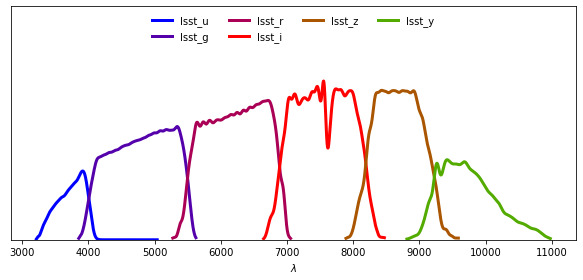

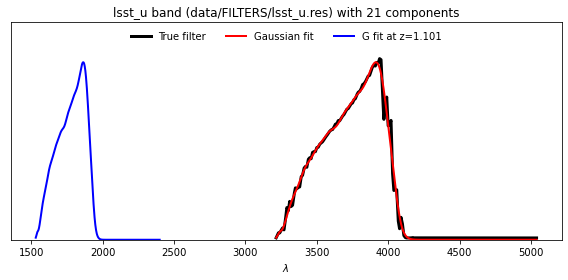

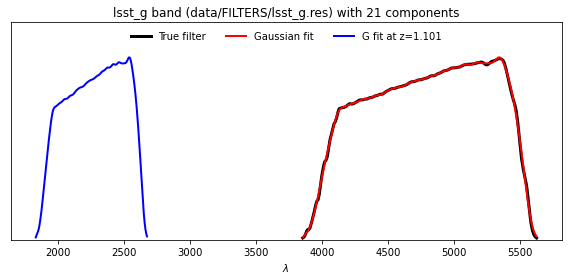

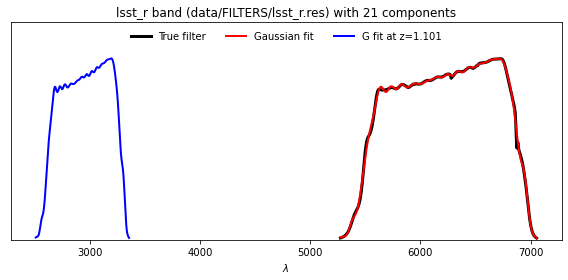

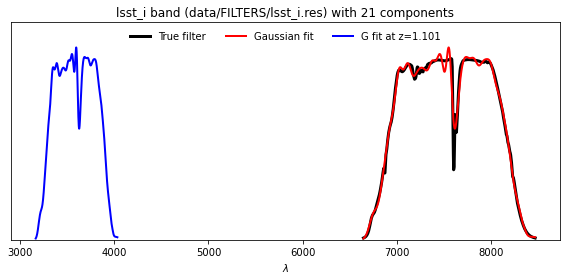

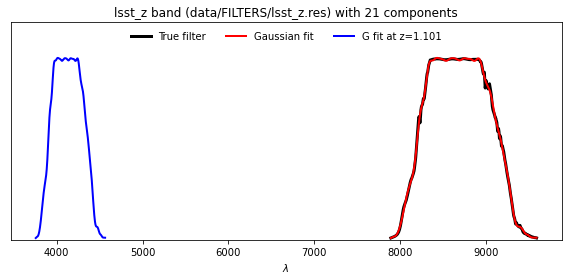

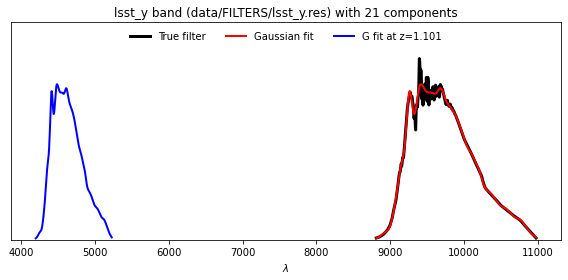

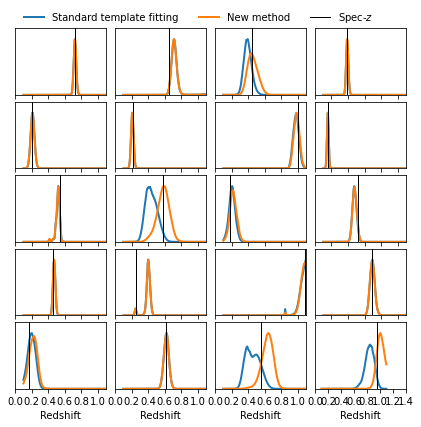

In [21]:
ncol = 4
fig, axs = plt.subplots(5, ncol, figsize=(7, 6), sharex=True, sharey=False)
axs = axs.ravel()
z = fluxredshifts[:, redshiftColumn]
sel = np.random.choice(nobj, axs.size, replace=False)
lw = 2
for ik in range(axs.size):
    k = sel[ik]
    print(k, end=" ")
    axs[ik].plot(redshiftGrid, pdfs_cww[k, :],lw=lw, label='Standard template fitting')# c="#2ecc71", 
    axs[ik].plot(redshiftGrid, pdfs[k, :], lw=lw, label='New method')  #, c="#3498db"
    axs[ik].axvline(fluxredshifts[k, redshiftColumn], c="k", lw=1, label=r'Spec-$z$')
    ymax = np.max(np.concatenate((pdfs[k, :], pdfs_cww[k, :])))
    axs[ik].set_ylim([0, ymax*1.2])
    axs[ik].set_xlim([0, 1.1])
    axs[ik].set_yticks([])
    axs[ik].set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
for i in range(ncol):
    axs[-i-1].set_xlabel('Redshift', fontsize=10)
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.4))
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.1, top=0.96)


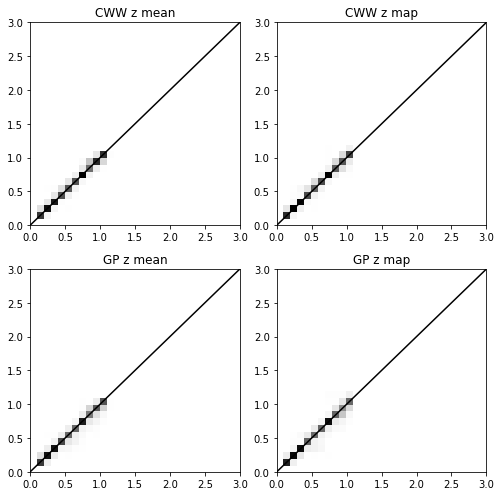

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
zmax = 3
rr = [[0, zmax], [0, zmax]]
nbins = 30
h = axs[0, 0].hist2d(metricscww[:, i_zt], metricscww[:, i_zm], nbins, cmap='Greys', range=rr)
hmin, hmax = np.min(h[0]), np.max(h[0])
axs[0, 0].set_title('CWW z mean')
axs[0, 1].hist2d(metricscww[:, i_zt], metricscww[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[0, 1].set_title('CWW z map')
axs[1, 0].hist2d(metrics[:, i_zt], metrics[:, i_zm], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 0].set_title('GP z mean')
axs[1, 1].hist2d(metrics[:, i_zt], metrics[:, i_zmap], nbins, cmap='Greys', range=rr, vmax=hmax)
axs[1, 1].set_title('GP z map')
axs[0, 0].plot([0, zmax], [0, zmax], c='k')
axs[0, 1].plot([0, zmax], [0, zmax], c='k')
axs[1, 0].plot([0, zmax], [0, zmax], c='k')
axs[1, 1].plot([0, zmax], [0, zmax], c='k')
fig.tight_layout()

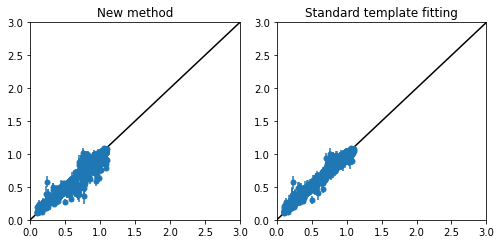

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
chi2s = ((metrics[:, i_zt] - metrics[:, i_ze])/metrics[:, i_std_ze])**2

axs[0].errorbar(metrics[:, i_zt], metrics[:, i_ze], yerr=metrics[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[1].errorbar(metricscww[:, i_zt], metricscww[:, i_ze], yerr=metricscww[:, i_std_ze], fmt='o', markersize=5, capsize=0)
axs[0].plot([0, zmax], [0, zmax], 'k')
axs[1].plot([0, zmax], [0, zmax], 'k')
axs[0].set_xlim([0, zmax])
axs[1].set_xlim([0, zmax])
axs[0].set_ylim([0, zmax])
axs[1].set_ylim([0, zmax])
axs[0].set_title('New method')
axs[1].set_title('Standard template fitting')

fig.tight_layout()

Text(0.5, 1.0, 'New method')

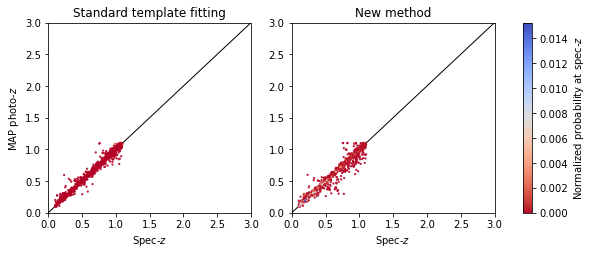

In [24]:
cmap = "coolwarm_r"
vmin = 0.0
alpha = 0.9
s = 5
fig, axs = plt.subplots(1, 2, figsize=(10, 3.5))
vs = axs[0].scatter(metricscww[:, i_zt], metricscww[:, i_zmap], 
                    s=s, c=pdfatZ_cww, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
vs = axs[1].scatter(metrics[:, i_zt], metrics[:, i_zmap], 
                    s=s, c=pdfatZ, cmap=cmap, linewidth=0, vmin=vmin, alpha=alpha)
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Normalized probability at spec-$z$')
for i in range(2):
    axs[i].plot([0, zmax], [0, zmax], c='k', lw=1, zorder=0, alpha=1)
    axs[i].set_ylim([0, zmax])
    axs[i].set_xlim([0, zmax])
    axs[i].set_xlabel('Spec-$z$')
axs[0].set_ylabel('MAP photo-$z$')

axs[0].set_title('Standard template fitting')
axs[1].set_title('New method')

## Conclusion
Don't be too harsh with the results of the standard template fitting or the new methods since both have a lot of parameters which can be optimized!

If the results above made sense, i.e. the redshifts are reasonnable for both methods on the mock data, then you can start modifying the parameter files and creating catalog files containing actual data! I recommend using less than 20k galaxies for training, and 1000 or 10k galaxies for the delight-apply script at the moment. Future updates will address this issue.